In [44]:
import pandas as pd
import numpy as np

from sklearn.model_selection import KFold, train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (mean_squared_error, mean_absolute_error, f1_score, recall_score,
                             precision_score, confusion_matrix, plot_confusion_matrix)


import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBClassifier

from utils import split_reservations
from features import X1_cxl_cols, X2_cxl_cols

In [3]:
pd.options.display.max_rows = 60
pd.options.display.max_columns = 70

In [4]:
h1_res = pd.read_pickle("pickle/h1_res.pick")
h2_res = pd.read_pickle("pickle/h2_res.pick")
h1_dbd = pd.read_pickle("pickle/h1_dbd.pick")
h2_dbd = pd.read_pickle("pickle/h2_dbd.pick")

In [5]:
X1_train, X1_test, y1_train, y1_test = split_reservations(h1_res, as_of_date="2017-08-01", features=X1_cxl_cols)

Training sample size: 38295 
 Testing Sample Size: 1765


In [6]:
y1_test

12815    1
12816    1
12859    1
12874    1
12911    1
        ..
40055    0
40056    0
40057    0
40058    0
40059    0
Name: IsCanceled, Length: 1765, dtype: int64

In [7]:
X2_train, X2_test, y2_train, y2_test = split_reservations(h2_res, as_of_date="2017-08-01", features=X2_cxl_cols)

Training sample size: 76320 
 Testing Sample Size: 3010


In [8]:
y1_train

0        0
1        0
2        0
3        0
4        0
        ..
40014    0
40020    0
40022    0
40032    0
40035    0
Name: IsCanceled, Length: 38295, dtype: int64

## H1 Final XGBoost Model

In [10]:
xgb_1 = XGBClassifier(objective='binary:logistic',
                      use_label_encoder=False,
                      eval_metric='logloss',
                      random_state=41,
                      n_jobs=-1,
                      learning_rate=0.11,
                      max_depth=5,
                      n_estimators=475
                          
)

xgb_model_1 = xgb_1.fit(X1_train, y1_train)

In [11]:
y1_test

12815    1
12816    1
12859    1
12874    1
12911    1
        ..
40055    0
40056    0
40057    0
40058    0
40059    0
Name: IsCanceled, Length: 1765, dtype: int64

In [16]:
PROB_THRESHOLD = 0.75

h1_pred_probas = xgb_model_1.predict_proba(X1_test)

df_h1_preds = pd.DataFrame(h1_pred_probas, columns=["no_cxl", "cxl_proba"])
df_h1_preds["prediction"] = df_h1_preds['cxl_proba'] >= PROB_THRESHOLD

df_h1_preds["actual"] = y1_test.to_numpy()

h1_f1_score = f1_score(y1_test, df_h1_preds["prediction"])
h1_pr_score = precision_score(y1_test, df_h1_preds["prediction"])
h1_re_score = recall_score(y1_test, df_h1_preds["prediction"])

print(f"""
F-1 Score: {h1_f1_score}
Precision Score: {h1_pr_score}
Recall Score: {h1_re_score}""")


F-1 Score: 0.49951783992285437
Precision Score: 0.9087719298245615
Recall Score: 0.34441489361702127


In [18]:
h1_f05_score = (1.25 * h1_pr_score * h1_re_score) / (0.25 * h1_pr_score + h1_re_score)
h1_f05_score

0.6844608879492601

In [72]:
# old, stable, not saving images properly
def make_confusion_matrix(y_test, y_predict, label_color='black', save_to=False, threshold=0.5, title=None, facecolor='#5c5c5c'):
    # Predict class 1 if probability of being in class 1 is greater than threshold
    # (model.predict(X_test) does this automatically with a threshold of 0.5)
    
    confusion = confusion_matrix(y_test, y_predict)
    
    fig, ax = plt.subplots(dpi=165, figsize=(7, 5))
    sns.set(font_scale=1.3)
    group_counts = ["{0:0.0f}".format(value) for value in confusion.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in confusion.flatten()/np.sum(confusion)]
    labels = [f"{v2}\n\n{v3}" for v2, v3 in zip(group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    
    label_font = {'family': 'Arial',
        'color': label_color,
        'weight': 'bold',
        'size': 17,
        }
    
    title_font = {'family': 'Arial',
        'color': label_color,
        'weight': 'bold',
        'size': 27,
        }
    
    sns.heatmap(confusion, annot=labels, fmt="", cmap="Blues", cbar=False,
               xticklabels=['will_come', 'will_cancel'],
               yticklabels=['will_come', 'will_cancel'])
    
    if title == None:
        title = "Confusion Matrix"
    plt.title(title, fontdict=label_font)
    plt.xlabel('Prediction', fontdict=label_font)
    plt.ylabel('Actual', fontdict=label_font)
    if save_to:
        plt.tight_layout()
        plt.savefig(save_to, dpi=170, facecolor=facecolor, bbox_inches="tight", pad_inches=1.6)


In [73]:
def get_preds(pred_probas, threshold):
    df_preds = pd.DataFrame(pred_probas, columns=["no_cxl_proba", "cxl_proba"])
    df_preds["prediction"] = df_preds['cxl_proba'] >= threshold
    df_preds["actual"] = y1_test.to_numpy()
    return df_preds

def get_fbeta_score(pred_probas, beta, threshold):
    df_preds = get_preds(pred_probas, threshold)
    precision = precision_score(y1_test, df_preds["prediction"])
    recall = recall_score(y1_test, df_preds["prediction"])
    fbeta_score = ((1 + beta**2) * precision * recall) / (beta**2 * precision + recall)
    return round(fbeta_score, 3)

def optimize_prob_threshold(model, beta=0.5, thresh_start=0.4, thresh_stop=0.95):
    
    pred_probas = xgb_model_1.predict_proba(X1_test)
    
    thresholds = np.arange(thresh_start, thresh_stop, 0.01)
    fbetas = {} # will hold {prob_thresh: resulting_fbeta_score}
    
    for t_val in thresholds:
        fbetas[t_val] = get_fbeta_score(pred_probas, beta, t_val)
    
    best_thresh = 0
    best_fbeta = 0
    
    for threshold, fb_score in fbetas.items():
        if fb_score > best_fbeta:
            best_thresh = threshold
            best_fbeta = fb_score
        else:
            continue
    
    df_preds = get_preds(pred_probas, best_thresh)
    make_confusion_matrix(df_preds.actual, df_preds.prediction, threshold = best_thresh)

    print(f"""Optimal probability threshold (to maximize F-{beta}): {best_thresh}
    F-{beta} Score: {h1_f1_score}""")
    
    return best_thresh, best_fbeta




Optimal probability threshold (to maximize F-0.5): 0.6000000000000002
    F-0.5 Score: 0.49951783992285437


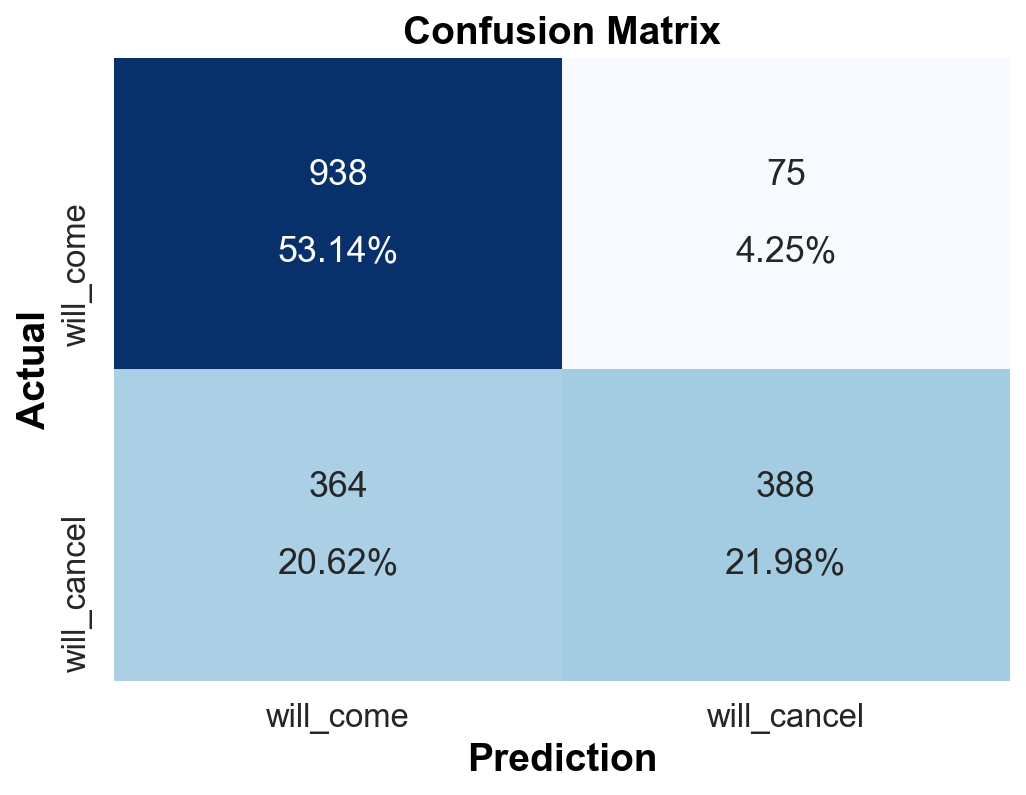

In [74]:
h1_best_thresh, h1_best_fbeta = optimize_prob_threshold(xgb_model_1)

In [15]:
df_h1_preds

,no_cxl,cxl_proba,prediction,actual
0,0.180378,0.819622,True,1
1,0.178129,0.821871,True,1
2,0.786236,0.213764,False,1
3,0.536743,0.463257,False,1
4,0.387287,0.612713,False,1
...,...,...,...,...
1760,0.925619,0.074381,False,0
1761,0.864955,0.135045,False,0
1762,0.940487,0.059513,False,0
1763,0.911407,0.088593,False,0


In [ ]:
import matplotlib.pyplot as plt
plt.hist(h1_pred_probas)

### First grid search results

**H1 grid search setup**
```
estimator = XGBClassifier(objective='binary:logistic',
                          use_label_encoder=False,
                          eval_metric='logloss',
                          random_state=42,
)

params = {
    'learning_rate': [0.0001,0.01],
    'max_depth': range(2,8,2),
    'n_estimators': [200, 300, 400]
}

grid_search_1 = GridSearchCV(
    estimator = estimator,
    param_grid = params,
    n_jobs=-1,
    verbose=100
)

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2,random_state=42)

```

**And the results**:
```
Fitting 5 folds for each of 18 candidates, totalling 90 fits
The best parameters are: 
 {'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 400}
CPU times: user 53.5 s, sys: 414 ms, total: 53.9 s
Wall time: 1h 27min 17s
```

R^2 score: 0.830629056415377

**H2 grid search setup was the same as H1 grid search setup (round 1)**

**And the results**:

```
Fitting 5 folds for each of 18 candidates, totalling 90 fits
The best parameters are: 
 {'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 400}
CPU times: user 1min 37s, sys: 262 ms, total: 1min 38s
Wall time: 1h 32min 4s
```

R^2 score: 0.8276818353712341

### Second Round

H1 setup & results
```
estimator = XGBClassifier(objective='binary:logistic',
                          use_label_encoder=False,
                          eval_metric='logloss',
                          random_state=42,
)

params = {
    'learning_rate': [0.005, 0.01, 0.05, 0.1],
    'max_depth': range(5,6,7),
    'n_estimators': [350, 400, 450]
}

grid_search_1 = GridSearchCV(
    estimator = estimator,
    param_grid = params,
    n_jobs=-1,
    verbose=100
)

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2,random_state=42)

# ---------RESULTS----------
Fitting 5 folds for each of 12 candidates, totalling 60 fits
The best parameters are: 
 {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 400}
CPU times: user 40.9 s, sys: 325 ms, total: 41.2 s
Wall time: 1h 37min 13s
```

R^2 score: 0.8514727908137794

H2 results (setup the same as H1 round 2):

```

# SETUP SAME AS H1 ROUND 2

# ---------RESULTS----------
Fitting 5 folds for each of 12 candidates, totalling 60 fits
The best parameters are: 
 {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 450}
CPU times: user 1min 29s, sys: 236 ms, total: 1min 29s
Wall time: 1h 41min 45s
```
R^2 score: 0.84904827933946

### Round 3

H1 setup different than H2 setup this time.

H1 setup:
```
estimator = XGBClassifier(objective='binary:logistic',
                          use_label_encoder=False,
                          eval_metric='logloss',
                          random_state=42,
                          max_depth=5
)

params = {
    'learning_rate': [0.08, 0.09, 0.1, 0.11, 0.12],
    'n_estimators': [380, 390, 400, 410, 420, 475]
}

grid_search_1 = GridSearchCV(
    estimator = estimator,
    param_grid = params,
    n_jobs=-1,
    verbose=100
)

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2,random_state=42)

# ---------RESULTS----------
Fitting 5 folds for each of 30 candidates, totalling 150 fits
The best parameters are: 
 {'learning_rate': 0.11, 'n_estimators': 475}
CPU times: user 49.1 s, sys: 437 ms, total: 49.5 s
Wall time: 4h 8min 47s
```
R^2 score: 0.854218671992012

And H2 setup:

```
estimator = XGBClassifier(objective='binary:logistic',
                          use_label_encoder=False,
                          eval_metric='logloss',
                          random_state=42,
)

# further tuning params
params = {
    'learning_rate': [0.08, 0.09, 0.1, 0.11, 0.12],
    'n_estimators': [440, 450, 475, 500, 550]
}


grid_search_2 = GridSearchCV(
    estimator = estimator,
    param_grid = params,
    n_jobs=-1,
    verbose=100
)

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2,random_state=42)

# ---------RESULTS----------
Fitting 5 folds for each of 25 candidates, totalling 125 fits
The best parameters are: 
 {'learning_rate': 0.12, 'n_estimators': 550}
CPU times: user 2min 8s, sys: 187 ms, total: 2min 8s
Wall time: 5h 5min 44s
```

R^2 score: 0.8564225387621328